# Transfert learning avec TensorFlow

## Introduction

Dans ce notebook, nous allons explorer le concept de transfert learning en utilisant TensorFlow.

### Objectif

L'objectif de ce notebook est de :

1. Comprendre le concept de transfert learning.
2. Implémenter le transfert learning en utilisant un modèle pré-entraîné dans TensorFlow.
3. Affiner le modèle pré-entraîné sur un ensemble de données personnalisé.

### 1. Importation des bibliothèques et chargement des données

Commençons par importer les bibliothèques nécessaires et charger notre ensemble de données. Pour cet exemple, nous utiliserons l'ensemble de données suivant:
https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

L'archive contient un fichier .json décrivant les données.
A partir du fichier .json, construisez un dataset Tensorflow. Pour cela :
1. Ouvrez le fichier .json, explorez les données.
2. Les données correspondant aux images contiennent successivement 3 canaux. Réorganisez les dimensions des images pour pouvoir les utiliser dans un dataset.
3. Récupérez les labels. Encodez les en one-hot.
4. Construisez le dataset, et préparez le pour l'entrainement.


In [30]:
from pathlib import Path
import json
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

with open(Path(path) / "shipsnet.json", "r") as f:
    ship = json.load(f)

images = np.array(ship["data"])
labels = np.array(ship["labels"])

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Labels distribution:", np.bincount(labels))

images = images.reshape((-1, 3, 80, 80)).transpose(0, 2, 3, 1)
images = images.astype("float32") / 255.0

X_train_ship, X_temp_ship, y_train_ship, y_temp_ship = train_test_split(
    images, labels, test_size=0.4, stratify=labels, random_state=42
)

X_val_ship, X_test_ship, y_val_ship, y_test_ship = train_test_split(
    X_temp_ship, y_temp_ship, test_size=0.5, stratify=y_temp_ship, random_state=42
)

print("Train:", X_train_ship.shape, y_train_ship.shape)
print("Val  :", X_val_ship.shape,   y_val_ship.shape)
print("Test :", X_test_ship.shape,  y_test_ship.shape)

num_classes = 2
y_train_ship_oh = to_categorical(y_train_ship, num_classes)
y_val_ship_oh = to_categorical(y_val_ship, num_classes)
y_test_ship_oh = to_categorical(y_test_ship, num_classes)

print("y_train_ship_oh:", y_train_ship_oh.shape)
print("y_val_ship_oh  :", y_val_ship_oh.shape)

Using Colab cache for faster access to the 'ships-in-satellite-imagery' dataset.
Path to dataset files: /kaggle/input/ships-in-satellite-imagery
Images shape: (4000, 19200)
Labels shape: (4000,)
Labels distribution: [3000 1000]
Train: (2400, 80, 80, 3) (2400,)
Val  : (800, 80, 80, 3) (800,)
Test : (800, 80, 80, 3) (800,)
y_train_ship_oh: (2400, 2)
y_val_ship_oh  : (800, 2)


### 2. Chargement du modèle pré-entrainé

Chargez le modèle Tensorflow ResNet50 entrainé sur imagenet en ne gardant que la partie avec couches convolutionnelles (option 'include_top'). Gelez les poids de toutes les couches du réseau (cette partie du modèle final ne sera pas entrainée).

In [33]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

for layer in base_model.layers:
    layer.trainable = False

### 3. Construction et compilation du modèle

Intégrez le modèle de ResNet50 dans un modèle final en rajoutant une couche de GlobalAveragePooling2D et deux couches Dense, puis compilez le modèle.

In [34]:
model_ship = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model_ship.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 4. Entrainement et visualisation des résultats

Entrainez le modèle final pour 10 epochs, puis visualisez les courbes d'accuracy et de loss.

In [35]:
history = model_ship.fit(
    X_train_ship,
    y_train_ship_oh,
    validation_data=(X_val_ship, y_val_ship_oh),
    epochs=10,
    verbose=0,
)


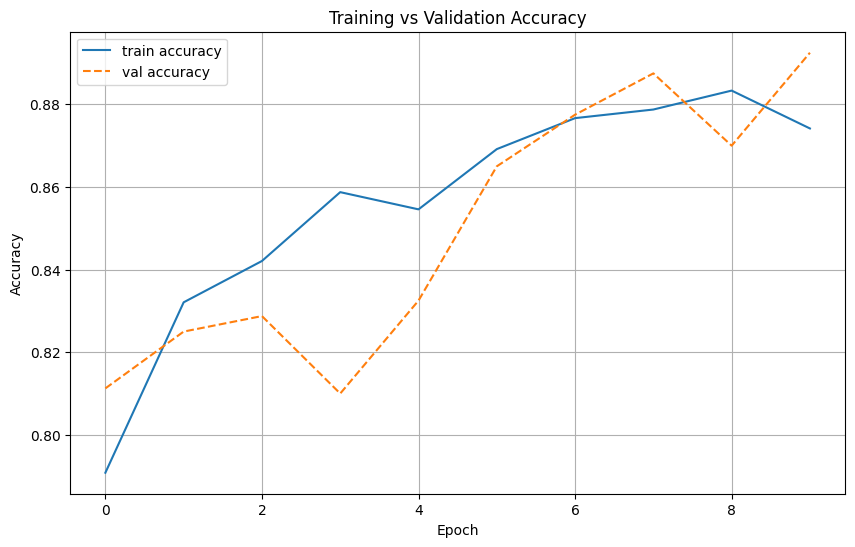

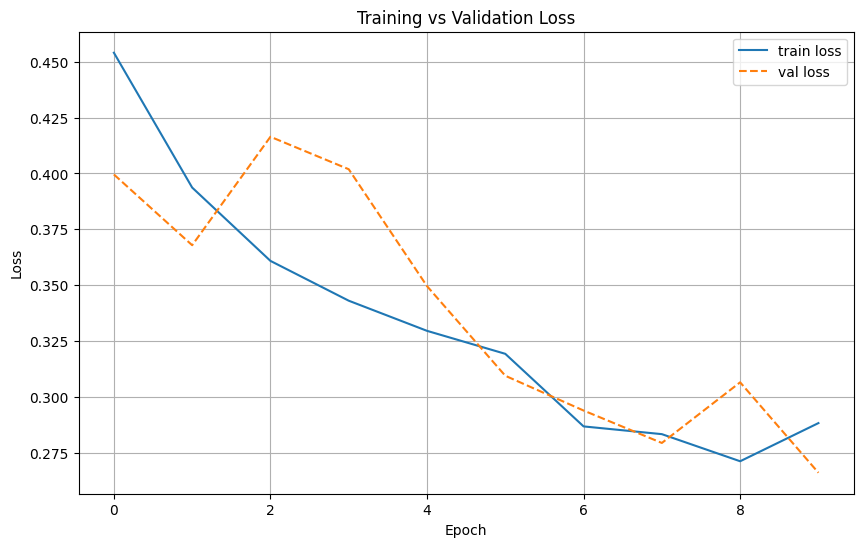

In [38]:
plt.figure(figsize=(10,6))
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], '--', label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], '--', label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### 5. Fine-tuning des paramètres

Décongelez les poids des deux dernières couches de convolution de ResNet50, puis recompilez le modèle final et poursuivez l'entrainement pour 5 epochs de plus

In [39]:
base_model.layers[-2].trainable = True
base_model.layers[-1].trainable = True

model_ship.fit(
    X_train_ship,
    y_train_ship_oh,
    validation_data=(X_val_ship, y_val_ship_oh),
    epochs=5,
    verbose=0,
)

### 6. Evaluez le modèle final sur l'ensemble de test

In [40]:
model_ship.evaluate(X_test_ship, y_test_ship_oh)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8905 - loss: 0.2665


[0.2807607352733612, 0.8812500238418579]